# Calibration - BC Model Observed Positive
In this notebook we calibrate the parameter of a bounded confidence model with observed only positive interactions, with Method of Simulated Moments.
At each step $k$ positive interactions are observed, and $m = edge\_per\_t - k$ negative interactions are not observed.

In order to replicate the model, at each time:
- simulate the observed interactions
- simulate m interactions with random pairs of nodes, extracted uniformly
- compare the number of positive simulated interactions with the number of positive observed interactions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path += ["../src"]
import simulator_BC as sim_bc
import estimation_epsilon_BC as est_bc
import jax_estimation_BC as jest_bc
from calibrator_blackit import Calibrator #i just commented few lines of code to remove the output print
#from black_it.calibrator import Calibrator
import pandas as pd
from black_it.samplers.halton import HaltonSampler
from black_it.samplers.random_forest import RandomForestSampler
from black_it.samplers.best_batch import BestBatchSampler
from black_it.loss_functions.msm import MethodOfMomentsLoss
from black_it.samplers.random_uniform import RandomUniformSampler
from typing import Sequence
import os
import contextlib
from scipy.special import expit
import torch
import importlib
from time import time

In [2]:
N, T, edge_per_t = 100, 200, 5
epsilon = 0.2
epsilon0 = 0.25
mu = 0.5
rho = 70

X, edges = jest_bc.simulator_stoch_np(N,T,edge_per_t,epsilon,mu,rho)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [3]:
#this function return the simulated list of edges, from X, edges, and epsilon
#it simulated edges[t]|X[t],u,v
#so it knows the picked nodes and their opinions
def simulate(X, edges, epsilon, rho = 100, seed = 1):
    edges_pred = []
    
    np.random.seed(seed)
    
    N = len(X[0])
    
    T = max(edges[:,3])
    edge_per_t = max(np.unique(edges[:,3], return_counts = True)[1])
    
    for t in range(T):
        
        edges_t = edges[edges[:,3] == t]
        positive_t = len(edges_t)
        for edge in edges_t:
            u,v,s,_ = edge
            dist = np.abs(X[t, u] - X[t, v])            
            s = int(np.random.random() < expit(rho * (epsilon - dist)))
            edges_pred.append([u,v,s,t])
        for edge in range(edge_per_t - positive_t):
            u,v = np.random.choice(N, 2, replace = False)
            dist = np.abs(X[t, u] - X[t, v])
            s = int(np.random.random() < expit(rho * (epsilon - dist)))
            edges_pred.append([u,v,s,t])                

    return np.array(edges_pred)

In [6]:
pred_edges = simulate(X, edges, 0.1)

mean_s = np.array(pd.DataFrame(pred_edges, columns = ["u", "v", "s", "t"]).groupby("t").mean()["s"])

In [4]:
#define a simulator class for simulating the BC model knowing the real edges and opinions
#the calibration will compare the arrays of signs: self.s and simulate_s([epsilon])
#i input theta = [epsilon], instead of epsilon, because the Calibrator of black-it is designed for calibrating a list of parameters
class BC_observe_positive_simulator_given_previous_time():
    def __init__(self, X, edges, mu, real_epsilon, rho = 100, seed = 1):
        self.T, self.N = X.shape
        self.edge_per_t = max(np.unique(edges[:,3], return_counts = True)[1])
        self.X = X
        self.edges = edges
        self.mu = mu
        self.real_epsilon = real_epsilon
        self.rho = rho
        self.seed = seed
        mean_s = np.array(pd.DataFrame(self.edges, columns = ["u", "v", "s", "t"]).groupby("t").mean()["s"])
        self.mean_s = mean_s[:,None]
        #self.mean_s = np.array(edges[:,:,2]).mean(axis = 1)[:,None]
    
    
    #this function return the simulated list of edges, from X, edges, and epsilon
    #it simulated edges[t]|X[t],u,v
    #so it knows the picked nodes and their opinions
    def simulate_edges(self, epsilon):
        edges_pred = []

        for t in range(self.T - 1):

            edges_t = self.edges[self.edges[:,3] == t]
            positive_t = len(edges_t)
            for edge in edges_t:
                u,v,s,_ = edge
                dist = np.abs(self.X[t, u] - self.X[t, v])            
                s = int(np.random.random() < expit(self.rho * (epsilon - dist)))
                edges_pred.append([u,v,s,t])
            for edge in range(self.edge_per_t - positive_t):
                u,v = np.random.choice(self.N, 2, replace = False)
                dist = np.abs(self.X[t, u] - self.X[t, v])
                s = int(np.random.random() < expit(self.rho * (epsilon - dist)))
                edges_pred.append([u,v,s,t])                

        return np.array(edges_pred)

    
    def simulate_mean_s(self, theta, _ = None, seed = None):
        epsilon, = theta
        
        if seed != None:
            np.random.seed(self.seed)
        
        pred_edges = self.simulate_edges(epsilon)
        mean_s_pred = np.array(pd.DataFrame(pred_edges, columns = ["u", "v", "s", "t"]).groupby("t").mean()["s"])
        
        return mean_s_pred[:, None] #Calibrator requires a time series of dim N, n_of_parameters"""

In [5]:
N, T, edge_per_t = 100, 400, 3

epsilon, mu = 0.22, 0.6

epsilon_bounds = [[0.], [1.]]
precisions = [0.0001]

In [6]:
X, edges = jest_bc.simulator_stoch_np(N, T, edge_per_t, epsilon, mu, seed = 1004, rho = 70)
s_edges = mean_s_pred = np.array(pd.DataFrame(edges, columns = ["u", "v", "s", "t"]).groupby("t").mean()["s"])

simulator_BC = BC_observe_positive_simulator_given_previous_time(X, edges, mu, epsilon)

In [7]:
s_pred = simulator_BC.simulate_mean_s([0.4])

In [14]:
"""BC_cal = define_calibrator_BC(simulator_BC, samplers = [sampler(batch_size)], loss = loss,
                              epsilon_bounds = epsilon_bounds, precisions = precisions, compare_all_s = compare_all_s)

epsilon_BCcal, loss_BCcal = BC_cal.calibrate(calibration_batches)
loss_epsilon_df = pd.DataFrame([{"epsilon": epsilon_BCcal[k,0], "loss": loss_BCcal[k]} for k in range(len(loss_BCcal))]).sort_values("epsilon").set_index("epsilon")


if plot_loss:
    fig, ax = plt.subplots(nrows = 1, ncols = 1)
    ax.plot(loss_epsilon_df)
    ax.vlines(x = simulator_BC.real_epsilon, ymin = -0.5, ymax = loss_epsilon_df.max(), colors = "red")

    estimated_epsilon = loss_epsilon_df.sort_values("loss").index[0]
    t1 = time()
    calibration = {"loss": loss_epsilon_df, "epsilon": estimated_epsilon}
    
    if return_time:
        calibration["time"] = t1-t0
    """

'BC_cal = define_calibrator_BC(simulator_BC, samplers = [sampler(batch_size)], loss = loss,\n                              epsilon_bounds = epsilon_bounds, precisions = precisions, compare_all_s = compare_all_s)\n\nepsilon_BCcal, loss_BCcal = BC_cal.calibrate(calibration_batches)\nloss_epsilon_df = pd.DataFrame([{"epsilon": epsilon_BCcal[k,0], "loss": loss_BCcal[k]} for k in range(len(loss_BCcal))]).sort_values("epsilon").set_index("epsilon")\n\n\nif plot_loss:\n    fig, ax = plt.subplots(nrows = 1, ncols = 1)\n    ax.plot(loss_epsilon_df)\n    ax.vlines(x = simulator_BC.real_epsilon, ymin = -0.5, ymax = loss_epsilon_df.max(), colors = "red")\n\n    estimated_epsilon = loss_epsilon_df.sort_values("loss").index[0]\n    t1 = time()\n    calibration = {"loss": loss_epsilon_df, "epsilon": estimated_epsilon}\n    \n    if return_time:\n        calibration["time"] = t1-t0\n    '

In [15]:
epsilon_bounds = [[0.], [0.5]]
precisions = [0.0001]
samplers = [HaltonSampler(6)]
loss = MethodOfMomentsLoss()
model_simulator_bc = simulator_BC.simulate_mean_s
real_data_s = simulator_BC.mean_s

BC_cal = Calibrator(real_data = real_data_s,
                    samplers = samplers,
                    loss_function = loss,
                    model = model_simulator_bc,
                    parameters_bounds = epsilon_bounds,
                    parameters_precision = precisions,
                    ensemble_size = 3,
                    saving_folder = None,
                    verbose = False,
                    n_jobs = 1#'initial_state'
                   )

In [16]:
calibration_batches = 200
epsilon_BCcal, loss_BCcal = BC_cal.calibrate(calibration_batches)

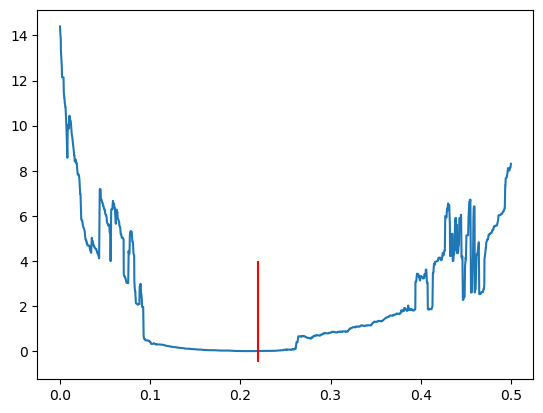

In [17]:
fig, ax = plt.subplots(nrows = 1, ncols = 1)
ax.plot(pd.DataFrame([epsilon_BCcal[:,0], loss_BCcal]).T.rename(columns = {0: "epsilon", 1: "loss"}).sort_values("epsilon").set_index("epsilon"))
ax.vlines(x = epsilon, ymin = -0.5, ymax = 4, colors = "red")

#### calibration_observed_positive_BC.py
Repeat the same routine, with the same functions in the src file.

In [21]:
from importlib import reload

import calibration_observed_positive_BC as cal_bc2

reload(cal_bc2)

<module 'calibration_observed_positive_BC' from '/home/jacopo.lenti/Projects/learning-od-step-by-step/src/calibration_observed_positive_BC.py'>

In [22]:
simulator_BC = cal_bc2.BC_observe_positive_simulator_given_previous_time(X, edges, mu, epsilon)

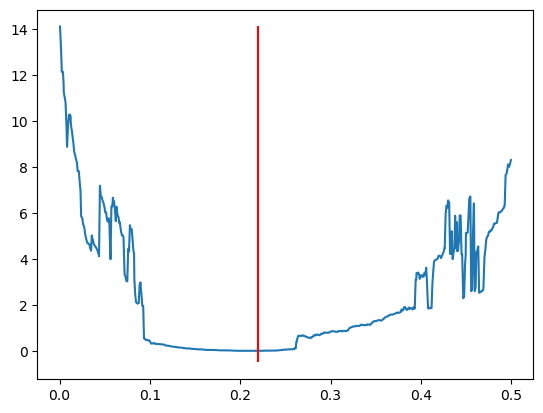

In [23]:
res_calibration = cal_bc2.calibrate_epsilon_BC(simulator_BC)

In [24]:
res_calibration["epsilon"], epsilon

(0.20770000000000002, 0.22)